# **Conformal Prediction Tutorial**

## 0. **Setup**

In [1]:
import torch
from torchvision import models
from datasets import *
from tqdm import tqdm

## **1. Conformal Prediction (classification)**

### **1.1 Overview**

Conformal prediction is a way to generate **prediction sets** for *any* model.
1. suppose we have a $K$-class classification model that outputs softmax scores for each class: $\hat{f}(x) \in [0,1]^K$
2. we reserve a moderate amount, e.g. 500, of unseen i.i.d samples $(X_1,Y_1),...,(X_n,Y_n)$ for *calibration*

Using the model $\hat{f}$ (1) and the calibration set (2), we want to construct a prediction set of possible labels $\mathcal{C}(X_{test}) \subset \{1,...,K\}$ that is valid in that

$$1-\alpha \leq \mathbb{P}(Y_{test}\in \mathcal{C}(X_{test}))\leq 1-\alpha +\frac{1}{n+1}$$

* $(X_{test},Y_{test})$ is a fresh test point from the same distribution 
* $\alpha\in[0,1]$ is a user-chosen error rate, such as 0.1

In words, the probability that the prediction set contains the true label is *almost* exactly $1-\alpha$, this is called *marginal coverage*

### **1.2 Calibration Step**

To construct the set $\mathcal{C}$ we perform a calibration step. The following is an example procedure
1. For every sample $(X_i,Y_i)$ in the calibration set, get conformal score $s_i=1-\hat{f}(X_i)_{Y_i}$ which is one minus the softmax output of the true class
2. define $\hat{q}$ to be the $\frac{\lceil (n+1)(1-\alpha) \rceil}{n}$ empirical quantile of $s_1,...,s_n$
3. for a new test point $X_{test}$, create a prediction set $\mathcal{C}(X_{test})=\{y:\hat{f}(X_{test})_y \geq 1-\hat{q}\}$

This algorithm is guaranteed to satisfy the desired condition above for any model and data distribution

#### **1.2.1 Code Example**

First get prepare the data and model

In [67]:
# load a model
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda').eval()

# load a validation set
bs = 256
val_loader = load_imagenet(bs,1234,False)

if "mnv3_scores.pt" not in os.listdir():
    # get softmax scores
    with torch.no_grad():
        sm_scores = torch.zeros((50000,1000))
        true_labels = torch.zeros(50000)
        for i,(imgs,labels) in enumerate(tqdm(val_loader)):
            # get calibration samples
            sm_scores[i*bs:i*bs+bs,:] = torch.nn.functional.softmax(model(imgs.to('cuda')),dim=1).cpu()
            true_labels[i*bs:i*bs+bs] = labels

    torch.save([sm_scores,true_labels],"mnv3_scores.pt")
else:
    sm_scores,true_labels = torch.load("mnv3_scores.pt")

n = 1000 # number of calibration points
alpha = 0.1 # 1-alpha is the desired coverage

# Split the softmax scores into calibration and validation sets (save the shuffling)
rand_idxs = torch.randperm(50000)
cal_idxs = rand_idxs[:n]
val_idxs = rand_idxs[n:]
cal_smx, val_smx = sm_scores[cal_idxs,:].numpy(), sm_scores[val_idxs,:].numpy()
cal_labels, val_labels = true_labels[cal_idxs].numpy().astype(int), true_labels[val_idxs].numpy().astype(int)

Next do conformal prediction procedure

In [68]:
# 1: get conformal scores
cal_scores = 1-cal_smx[np.arange(n),cal_labels]

# 2: get adjusted quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(cal_scores, q_level, interpolation='higher')

# 3: form prediction sets
prediction_sets = val_smx >= (1-qhat)

# Calculate empirical coverage
# Here we check whether the true label is part of the predictions set
# Prediction set is a mask of the classes above the threshold so if the
# mask is set at the true class then it is covered
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")

The empirical coverage is: 0.9029387755102041


/tmp/ipykernel_643444/1558666706.py:6: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(cal_scores, q_level, interpolation='higher')


Show examples

no norm


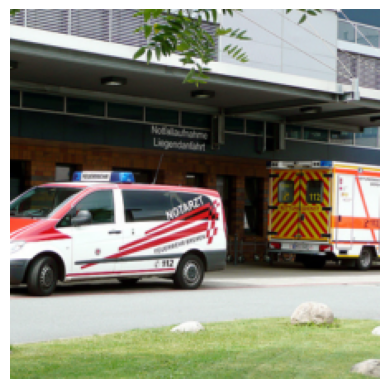

The prediction set is: [[' ambulance', 0.3864], [' moving van', 0.1212], [' tow truck', 0.0514], [' police van', 0.0491]]
The ground truth label is: ambulance


In [91]:
val_loader = load_imagenet(256,1234,False,norm=False)
i = 20390
img,label = val_loader.dataset[i]
prediction_set = sm_scores[i] > 1-qhat
plt.imshow(img.permute(1,2,0))
plt.axis('off')
plt.show()
class_ids = [[val_loader.dataset.class_name_map[val_loader.dataset.class_id_list[id]],round(torch.max(sm_scores[i][id]).item(),4)] for id in prediction_set.nonzero().view(-1)]
class_ids.sort(key = lambda x: -x[1])
print(f"The prediction set is: {class_ids}")
print(f"The ground truth label is:{val_loader.dataset.class_name_map[val_loader.dataset.class_id_list[label]]}")

# **Conformal Prediction Student Teacher**

We have the option of selecting the student or the teacher for prediction. We want to design a policy that determines when to select each. However, we want to gaurantee that our policy achieves a minimum level of performance. Specifically, we say that our policy must match the teacher $p$ percent of the time. A trivial way to do this would be to just choose the teacher every time but this is not useful since it is too expensive. Formally we can say we want
$$\mathbb{P}(\mathcal{P}(x) \neq \mathcal{P}_t(x)) \leq \alpha$$

Let's say that the model chooses the student if confidence is above a threshold $\lambda$. Formally,
$$\mathcal{P}_\lambda(x) = \begin{cases}\underset{k}{\text{argmax}}\,\,\hat{f}_s(x),& \text{max}\,\,\hat{f}_s(x) \geq \lambda\\
                         \underset{k}{\text{argmax}}\,\,\hat{f}_t(x),& \text{max}\,\,\hat{f}_s(x) < \lambda\end{cases}$$
Then, as $\lambda$ grows, the model picks the teacher more and becomes more conservative. We use conformal risk control to find the value $\hat{\lambda}$ such that we control for the fraction of time our policy will match the teacher model. Formally,
$$\mathbb{E}[\mathbf{1}_{\mathcal{P}_{\hat{\lambda}}(x_{test})\neq\mathcal{P}_t(x_{test})}] \leq \alpha$$

We can define the empirical risk as $\hat{R}(\lambda) = \frac{1}{n}\sum_{i=1}^n\mathbf{1}_{\mathcal{P}_{\hat{\lambda}}(x_{test})\neq\mathcal{P}_t(x_{test})}$. Then we select $\hat{\lambda}$ as ...

In words, we select the threshold such that the policy matches at least $(1-\alpha)$ of the teacher's performance

In [20]:
import torch
from scipy.optimize import brentq

In [2]:
corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']
# load the confidence scores
clean_embds,clean_labels,clean_preds = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/clean224.pt")
clean_embds128,clean_labels128,clean_preds128 = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/clean128.pt")
corr_embds = []
corr_labels = []
corr_preds = []
corr_embds128 = []
corr_labels128 = []
corr_preds128 = []
corr_embds64 = []
corr_labels64 = []
corr_preds64 = []
for i,corr in enumerate(corruptions):
    e,l,p = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/corr224_"+corr+".pt")
    e128,l128,p128 = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/corr128_"+corr+".pt")
    # e64,l64,p64 = torch.load("embds/corr64_"+corr+".pt")
    corr_embds.append(e)
    corr_labels.append(l)
    corr_preds.append(p)
    corr_embds128.append(e128)
    corr_labels128.append(l128)
    corr_preds128.append(p128)

In [27]:
# this is just for the first corruption
student_confs,student_decs = torch.max(corr_preds128[0],dim=1)
teacher_confs,teacher_decs = torch.max(corr_preds[0],dim=1)

In [96]:
# generate the split, calibration on 1000 and validation on 49000
n = 1000
alpha = 0.1
rand_idxs = torch.randperm(50000)
cal_idxs = rand_idxs[:n]
val_idxs = rand_idxs[n:]

student_cal_scores = student_confs[cal_idxs]
student_cal_preds = student_decs[cal_idxs]
teacher_cal_preds = teacher_decs[cal_idxs]

student_val_scores = student_confs[val_idxs]
student_val_preds = student_decs[val_idxs]
teacher_val_preds = teacher_decs[val_idxs]

In [97]:
t = 0.1
(((student_cal_scores >= t)*student_cal_preds + (student_cal_scores < t)*teacher_cal_preds) == teacher_cal_preds).float().mean()

tensor(0.4700)

In [98]:
# zero-one loss
def zo_loss(p_pred_set,t_pred_set):
    return (p_pred_set != t_pred_set).float().mean()

# the lambda hat threshold, we want the largest lambda hat that ...
# def lamhat_threshold(lam,cal_scores,cal_labels): 
#     return zo_loss(cal_scores>=lam, cal_labels) - ((n+1)/n*alpha - 1/(n+1))
def lamhat_threshold(lam): 
    p_set = (student_cal_scores >= lam)*student_cal_preds + (student_cal_scores < lam)*teacher_cal_preds
    return zo_loss(p_set, teacher_cal_preds) - ((n+1)/n*alpha - 1/(n+1))

In [99]:
lamhat = brentq(lamhat_threshold, 0, 1)
p_set = (student_val_scores >= lamhat)*student_val_preds + (student_val_scores < lamhat)*teacher_val_preds
print(f"The empirical ZOL is: {zo_loss(p_set, teacher_val_preds)} and the threshold value is: {lamhat}")

The empirical ZOL is: 0.10410203784704208 and the threshold value is: 0.5735025703915342
